# RNA-seqカウントデータの前処理(2)

- データの読み込み
- カウントデータの正規化（ RPM/FPM, FPKM, TPM)
- サンプル間のクラスタリング　
- 遺伝子のアノテーション( transcript_idとgene_idの対応、gene_idに対応したdescriptionの付与 )
- 発現量比 ( fold-change )の計算

### 2.データファイルの読み込み

#### 準備
pandas を pd としてインポートします。同様に numpy を np としてインポートします

In [1]:
# モジュールのimport
import sys
import pandas as pd
import numpy as np

# versionの確認
print(sys.version)
print(pd.__version__) # pandasのバージョン確認
print(np.__version__) # numpyのバージョン確認

3.12.8 | packaged by conda-forge | (main, Dec  5 2024, 14:25:12) [Clang 18.1.8 ]
2.2.2
2.0.2


In [2]:
# カウントデータをまとめたファイル ( counts_kalisto.tsv ) のパスを指定
count_file = 'data/counts_kallisto.tsv'

#### カウントデータファイルについて<br>
counts_kallisto.tsvを開くと以下のようになっています<br>
```
target_id	eff_length	SRR17223720	SRR17223721	SRR17223722	SRR17223723	SRR17223724	SRR17223725
ENSMUST00000178537.2	6.74193	0.0	0.0	0.0	0.0	0.0	0.0
ENSMUST00000178862.2	7.65825	0.0	0.0	0.0	0.0	0.0	0.0
ENSMUST00000196221.2	5.34639	0.0	0.0	0.0	0.0	0.0	0.0
ENSMUST00000179664.2	6.27959	0.0	0.0	0.0	0.0	0.0	0.0
ENSMUST00000177564.2	8.56364	0.0	0.0	0.0	0.0	0.0	0.0
... 以下省略
```
1行目は列タイトルを表すヘッダー行です<br>
2行目以降からがデータ行です。一番左の列が遺伝子idになっているのでこれをインデックスに用います

`pd.read_table()` メソッドの`index_col`オプションを指定して読み込みます<br>

- index_col...インデックスとして用いる列を数字で指定します

In [3]:
df = pd.read_table(count_file, index_col=0)

`pd.read_table(path/to/file)` のかわりに`pd.read_csv(path/to/file,sep='\t') `を用いることもできます<br>
`sep='\t'`は`delimiter='\t'` も使えます

#### データの概観
データを概観してみましょう

In [4]:
# head()で列名とインデックスが正しく読み込まれているかを確認します
df.head()

,eff_length,SRR17223720,SRR17223721,SRR17223722,SRR17223723,SRR17223724,SRR17223725
target_id,,,,,,,
ENSMUST00000178537.2,6.74193,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUST00000178862.2,7.65825,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUST00000196221.2,5.34639,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUST00000179664.2,6.27959,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUST00000177564.2,8.56364,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# 'eff_length'列だけ確認
df.eff_length.head()

target_id
ENSMUST00000178537.2    6.74193
ENSMUST00000178862.2    7.65825
ENSMUST00000196221.2    5.34639
ENSMUST00000179664.2    6.27959
ENSMUST00000177564.2    8.56364
Name: eff_length, dtype: float64

カウントデータファイルの行数と列数を確認します

In [6]:
# データ件数を確認
df.shape

(117062, 7)

#### 列名を変更する

In [7]:
# 列名を変更するための対応表
names = {'SRR17223720': 'wt_1',
         'SRR17223721': 'wt_2',
         'SRR17223722': 'wt_3',
         'SRR17223723': 'mutant_1',
         'SRR17223724': 'mutant_2',
         'SRR17223725': 'mutant_3'}

`rename()` を `axis=1` を適用して使い、列名を変更します

In [8]:
df = df.rename(mapper=names, axis=1)

`rename()` を使わなくても、既存の列を別名でコピーした後で元の列を削除、という方法でも可能です
```
df['wt_1'] = df['SRR17223720']
del df['SRR17223720']
```

In [9]:
df.head()

,eff_length,wt_1,wt_2,wt_3,mutant_1,mutant_2,mutant_3
target_id,,,,,,,
ENSMUST00000178537.2,6.74193,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUST00000178862.2,7.65825,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUST00000196221.2,5.34639,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUST00000179664.2,6.27959,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUST00000177564.2,8.56364,0.0,0.0,0.0,0.0,0.0,0.0


カウントデータ部分のみを切り出し

In [10]:
df_count = df[['wt_1','wt_2','wt_3','mutant_1','mutant_2','mutant_3']]

In [11]:
# スライスで指定する場合　
df.iloc[:, 1:7]

,wt_1,wt_2,wt_3,mutant_1,mutant_2,mutant_3
target_id,,,,,,
ENSMUST00000178537.2,0.00000,0.0000,0.0000,0.00000,0.00000,0.00000
ENSMUST00000178862.2,0.00000,0.0000,0.0000,0.00000,0.00000,0.00000
ENSMUST00000196221.2,0.00000,0.0000,0.0000,0.00000,0.00000,0.00000
ENSMUST00000179664.2,0.00000,0.0000,0.0000,0.00000,0.00000,0.00000
ENSMUST00000177564.2,0.00000,0.0000,0.0000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...
ENSMUST00000214850.2,0.00000,0.0000,0.0000,0.00000,0.00000,0.00000
ENSMUST00000116469.3,0.00000,0.0000,0.0000,0.00000,0.00000,0.00000
ENSMUST00000175694.2,2.98714,13.4728,21.9117,1.30724,4.55426,1.02826


#### ファイルの保存
保存用に`output/`フォルダを用意し, estimate_countのみのデータを`count_raw.tsv`として保存します

In [12]:
# estimate_countのみのデータの保存
df_count.to_csv('output/count_raw.tsv', sep = '\t')

シェルコマンド head を使って確認してみます。<br>
`%%bash`でJupyter notebookのセル内でbashコマンドを実行させることができます

In [13]:
%%bash
head output/count_raw.tsv

target_id	wt_1	wt_2	wt_3	mutant_1	mutant_2	mutant_3
ENSMUST00000178537.2	0.0	0.0	0.0	0.0	0.0	0.0
ENSMUST00000178862.2	0.0	0.0	0.0	0.0	0.0	0.0
ENSMUST00000196221.2	0.0	0.0	0.0	0.0	0.0	0.0
ENSMUST00000179664.2	0.0	0.0	0.0	0.0	0.0	0.0
ENSMUST00000177564.2	0.0	0.0	0.0	0.0	0.0	0.0
ENSMUST00000179520.2	0.0	0.0	0.0	0.0	0.0	0.0
ENSMUST00000179883.2	0.0	0.0	0.0	0.0	0.0	0.0
ENSMUST00000195858.2	0.0	0.0	0.0	0.0	0.0	0.0
ENSMUST00000179932.2	0.0	0.0	0.0	0.0	0.0	0.0


### 3. カウントデータの正規化
#### Step1. リード数で正規化 (RPM/FPM)

100万リードあたりのカウント数に揃えます<br>
RPM = reads per million, FPM = fragments per million<br>
ほぼ同じ意味で用いられているので, 本講義では「FPM」を使います<br>
<br>
カウントデータをいったん別のデータフレームとしてコピーしておきます

In [14]:
df_tmp = df_count.copy()

In [15]:
df_tmp.iloc[6085:6090,] # head()だと0.0ばかりになる

,wt_1,wt_2,wt_3,mutant_1,mutant_2,mutant_3
target_id,,,,,,
ENSMUST00000212686.2,66.4791,91.8426,177.0430,79.453100,186.7240,36.12280
ENSMUST00000034369.10,194.1700,152.8820,367.0170,188.466000,384.7460,204.43100
ENSMUST00000212938.2,42.1595,29.3632,57.3888,32.338600,0.0000,8.82529
ENSMUST00000212876.2,0.0000,18.9861,0.0000,0.018553,80.5943,25.10500
ENSMUST00000212595.2,125.6950,57.5033,78.6351,42.041200,13.9363,0.00000


In [16]:
# リード数の合計　sum()を使って計算
sum_count = df_tmp.sum()

In [17]:
sum_count

wt_1        1.842179e+07
wt_2        2.374667e+07
wt_3        2.988983e+07
mutant_1    1.600325e+07
mutant_2    1.990828e+07
mutant_3    1.629465e+07
dtype: float64

In [18]:
# 100万リードあたりに揃える
df_tmp = 10**6 * df_tmp / sum_count

In [19]:
df_tmp.iloc[6085:6090,]

,wt_1,wt_2,wt_3,mutant_1,mutant_2,mutant_3
target_id,,,,,,
ENSMUST00000212686.2,3.608722,3.867599,5.923184,4.964809,9.379211,2.216850
ENSMUST00000034369.10,10.540237,6.438040,12.278991,11.776731,19.325924,12.545894
ENSMUST00000212938.2,2.288567,1.236519,1.920011,2.020752,0.000000,0.541606
ENSMUST00000212876.2,0.000000,0.799527,0.000000,0.001159,4.048279,1.540689
ENSMUST00000212595.2,6.823171,2.421531,2.630831,2.627041,0.700025,0.000000


リード数の合計が100万に揃っていることを確認します

In [20]:
df_tmp.sum()

wt_1        1000000.0
wt_2        1000000.0
wt_3        1000000.0
mutant_1    1000000.0
mutant_2    1000000.0
mutant_3    1000000.0
dtype: float64

`normalize_per_million_reads()` として関数化しておきます

In [21]:
def normalize_per_million_reads(df):
    sum_count = df.sum()
    return 10**6 * df / sum_count

カウントデータに適用

In [22]:
df_count_fpm = normalize_per_million_reads(df_count)

確認

In [23]:
df_count_fpm.sum()

wt_1        1000000.0
wt_2        1000000.0
wt_3        1000000.0
mutant_1    1000000.0
mutant_2    1000000.0
mutant_3    1000000.0
dtype: float64

FPM正規化を行った結果を `count_fpm.tsv` として保存します

In [24]:
df_count_fpm.to_csv('output/count_fpm.tsv', sep='\t')

#### Step2. 遺伝子長による正規化 (RPKM/FPKM)
上で求めたFPMをさらに遺伝子長で割ってFPKMを求めます<br>
FPKM = fragments per kilobase of exon per million reads mapped <br>
今回用いたsingle-endの場合、RPKM = reads per kilobase of exon per million reads mapped と呼ばれますが, <br>
FPKM/RPKMはほぼ同じ意味で用いられています

各遺伝子の長さを抽出しておきます。<br>
kallistoでは実際の配列長（abundance.tsvの`length`列）ではなく、`eff_length`列でTPMを計算しているので、<br>
本講義でも`eff_length`列の値を用います<br>
参考　次世代シーケンサーデータの解析手法 第15回 RNA-seq 解析(その3）<br>
DOI: https://doi.org/10.4109/jslab.31.25


In [25]:
gene_length = df['eff_length']

In [26]:
gene_length

target_id
ENSMUST00000178537.2      6.74193
ENSMUST00000178862.2      7.65825
ENSMUST00000196221.2      5.34639
ENSMUST00000179664.2      6.27959
ENSMUST00000177564.2      8.56364
                          ...    
ENSMUST00000214850.2     70.74100
ENSMUST00000116469.3    757.16000
ENSMUST00000175694.2    141.84100
ENSMUST00000117697.2    767.16000
ENSMUST00000213427.2     49.17080
Name: eff_length, Length: 117062, dtype: float64

下のように書くとうまくいきません（縦方向にブロードキャストされてしまうため）

In [27]:
# df_tmp / gene_length

一列ずつ計算することは可能です

In [28]:
# df_tmp["batch_1"] / gene_length * 10**3

##### for ループを使う方法
データフレームをforループで回すと、列名が取得できるのでそれを利用します

In [29]:
# テスト用にDataFrameをコピーしてから
df_tmp = df_count_fpm.copy()

for col_name in df_tmp:
    df_tmp[col_name] = df_tmp[col_name] / gene_length * 10**3

In [30]:
df_tmp.iloc[6085:6090,]

,wt_1,wt_2,wt_3,mutant_1,mutant_2,mutant_3
target_id,,,,,,
ENSMUST00000212686.2,9.442812,10.120208,15.498983,12.991238,24.542243,5.800751
ENSMUST00000034369.10,9.252640,5.651568,10.778987,10.338083,16.965065,11.013286
ENSMUST00000212938.2,4.826572,2.607809,4.049289,4.261751,0.000000,1.142244
ENSMUST00000212876.2,0.000000,1.002969,0.000000,0.001454,5.078378,1.932723
ENSMUST00000212595.2,9.396237,3.334708,3.622936,3.617716,0.964010,0.000000


以下では`.items()`を利用する方法を紹介します。

In [31]:
df_tmp = df_count_fpm.copy()

for col_name, col in df_tmp.items():
    df_tmp[col_name] = col / gene_length * 10**3

In [32]:
df_tmp.iloc[6085:6090,]

,wt_1,wt_2,wt_3,mutant_1,mutant_2,mutant_3
target_id,,,,,,
ENSMUST00000212686.2,9.442812,10.120208,15.498983,12.991238,24.542243,5.800751
ENSMUST00000034369.10,9.252640,5.651568,10.778987,10.338083,16.965065,11.013286
ENSMUST00000212938.2,4.826572,2.607809,4.049289,4.261751,0.000000,1.142244
ENSMUST00000212876.2,0.000000,1.002969,0.000000,0.001454,5.078378,1.932723
ENSMUST00000212595.2,9.396237,3.334708,3.622936,3.617716,0.964010,0.000000


##### データフレームを転置してから計算する方法

In [33]:
# テスト用にFPMをコピー
df_tmp = df_count_fpm.copy()

# df_tmpを転置してFPMを遺伝子長で割り, 1000をかける
df_tmp = df_tmp.T / gene_length * 10**3

# 戻す（もう一度転置する）
df_tmp = df_tmp.T

In [34]:
df_tmp.iloc[6085:6090,]

,wt_1,wt_2,wt_3,mutant_1,mutant_2,mutant_3
target_id,,,,,,
ENSMUST00000212686.2,9.442812,10.120208,15.498983,12.991238,24.542243,5.800751
ENSMUST00000034369.10,9.252640,5.651568,10.778987,10.338083,16.965065,11.013286
ENSMUST00000212938.2,4.826572,2.607809,4.049289,4.261751,0.000000,1.142244
ENSMUST00000212876.2,0.000000,1.002969,0.000000,0.001454,5.078378,1.932723
ENSMUST00000212595.2,9.396237,3.334708,3.622936,3.617716,0.964010,0.000000


##### applyを使い各列に関数を適用する方法
`divide_by_length()`という関数を作り、`apply()` で適用します

In [35]:
# 列を入力とし、各要素を遺伝子長で割る処理を行う関数を定義
def divide_by_length(S):
    return S / gene_length * 10**3

In [36]:
# テスト用にFPMをコピー
df_tmp = df_count_fpm.copy()

# applyでdivide_by_length()関数を適用して先頭だけ確認
df_tmp.apply(divide_by_length).iloc[6085:6090,]

,wt_1,wt_2,wt_3,mutant_1,mutant_2,mutant_3
target_id,,,,,,
ENSMUST00000212686.2,9.442812,10.120208,15.498983,12.991238,24.542243,5.800751
ENSMUST00000034369.10,9.252640,5.651568,10.778987,10.338083,16.965065,11.013286
ENSMUST00000212938.2,4.826572,2.607809,4.049289,4.261751,0.000000,1.142244
ENSMUST00000212876.2,0.000000,1.002969,0.000000,0.001454,5.078378,1.932723
ENSMUST00000212595.2,9.396237,3.334708,3.622936,3.617716,0.964010,0.000000


`pandas.DataFrame`メソッドの `divide()` を使用する方法もあります

In [37]:
# テスト用にFPMをコピー
df_tmp = df_count_fpm.copy()

df_tmp = df_tmp.divide(gene_length, axis='index') * 10**3
df_tmp.iloc[6085:6090,]

,wt_1,wt_2,wt_3,mutant_1,mutant_2,mutant_3
target_id,,,,,,
ENSMUST00000212686.2,9.442812,10.120208,15.498983,12.991238,24.542243,5.800751
ENSMUST00000034369.10,9.252640,5.651568,10.778987,10.338083,16.965065,11.013286
ENSMUST00000212938.2,4.826572,2.607809,4.049289,4.261751,0.000000,1.142244
ENSMUST00000212876.2,0.000000,1.002969,0.000000,0.001454,5.078378,1.932723
ENSMUST00000212595.2,9.396237,3.334708,3.622936,3.617716,0.964010,0.000000


データフレームを転置させて計算する方法を `normalize_per_kilobase()` として関数化しておきます

In [38]:
def normalize_per_kilobase(df, gene_length):
    df_tmp = df.copy()
    df_tmp = (df.T * 10**3 / gene_length).T
    return df_tmp

In [39]:
df_count_fpkm = normalize_per_kilobase(df_count_fpm, gene_length)

In [40]:
df_count_fpkm.iloc[6085:6090,]

,wt_1,wt_2,wt_3,mutant_1,mutant_2,mutant_3
target_id,,,,,,
ENSMUST00000212686.2,9.442812,10.120208,15.498983,12.991238,24.542243,5.800751
ENSMUST00000034369.10,9.252640,5.651568,10.778987,10.338083,16.965065,11.013286
ENSMUST00000212938.2,4.826572,2.607809,4.049289,4.261751,0.000000,1.142244
ENSMUST00000212876.2,0.000000,1.002969,0.000000,0.001454,5.078378,1.932723
ENSMUST00000212595.2,9.396237,3.334708,3.622936,3.617716,0.964010,0.000000


In [41]:
# 保存する
df_count_fpkm.to_csv('output/count_fpkm.tsv', sep='\t')

#### Step3. TPM 正規化
TPM = transcripts per million (transcripts per kilobase million)<br> 
TPM の説明については以下のページが詳しいです https://bi.biopapyrus.jp/ <br> 

FPKM/RPKM のときとは逆に、長さ1,000bpあたりのリード数を求めてから、総リード数を100万に揃えます

In [42]:
# テスト用にカウントデータをコピー
df_tmp = df_count.copy()

In [43]:
df_tmp = normalize_per_kilobase(df_tmp, gene_length) #長さ1,000bpあたりのリード数
df_tmp = normalize_per_million_reads(df_tmp) #総リード数を100万に揃える

In [44]:
df_tmp.iloc[6085:6090,]

,wt_1,wt_2,wt_3,mutant_1,mutant_2,mutant_3
target_id,,,,,,
ENSMUST00000212686.2,13.375947,14.821739,22.403762,18.415533,36.517768,8.398009
ENSMUST00000034369.10,13.106564,8.277109,15.581013,14.654594,25.243265,15.944429
ENSMUST00000212938.2,6.836943,3.819315,5.853242,6.041180,0.000000,1.653678
ENSMUST00000212876.2,0.000000,1.468917,0.000000,0.002062,7.556400,2.798090
ENSMUST00000212595.2,13.309972,4.883908,5.236949,5.128239,1.434403,0.000000


RPKM/FPKMと違い、合計が100万となっています

In [45]:
df_tmp.sum()

wt_1        1000000.0
wt_2        1000000.0
wt_3        1000000.0
mutant_1    1000000.0
mutant_2    1000000.0
mutant_3    1000000.0
dtype: float64

`normalize_tpm()` として関数化しておきます

In [46]:
def normalize_tpm(df, gene_length):
    df_tmp = df.copy()
    df_tmp = normalize_per_kilobase(df_tmp, gene_length)
    df_tmp = normalize_per_million_reads(df_tmp)
    return df_tmp

In [47]:
df_count_tpm = normalize_tpm(df_count, gene_length)

In [48]:
df_count_tpm.sum() #  確認

wt_1        1000000.0
wt_2        1000000.0
wt_3        1000000.0
mutant_1    1000000.0
mutant_2    1000000.0
mutant_3    1000000.0
dtype: float64

In [49]:
# 保存
df_count_tpm.to_csv('output/count_tpm.tsv', sep='\t')

* 参考）numpyを使った高速バージョンとの比較 <br>

`%%timeit`はコードの時間計測を何回か試し, その中で最速の時間と平均値を返すマジックコマンドです

In [50]:
%%timeit
# pandasで実装したもの
normalize_tpm(df_count, gene_length)

20.7 ms ± 443 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [51]:
# valuesによりnumpy.ndarrayとして数値データを抽出
counts = df_count.values
length =gene_length.values

In [52]:
%%timeit
# numpyで計算
# 長さで正規化。行方向へbroadcastを行うため、reshapeしておく必要がある
counts_tmp = counts / length.reshape(-1, 1) * 1000
# カウント数の各列の合計を求めておく
sum_count = counts_tmp.sum(axis=0)
# 100万カウントに揃える
tpm = counts_tmp / sum_count * 1000000

3.8 ms ± 30.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### 4. TPM正規化したデータのクラスタリング
matplotlib と scipy の必要モジュールをインポートします

In [53]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [54]:
# 転置
tpm_t = df_count_tpm.T

# 確認
tpm_t.iloc[:,0:3]

target_id,ENSMUST00000178537.2,ENSMUST00000178862.2,ENSMUST00000196221.2
wt_1,0.0,0.0,0.0
wt_2,0.0,0.0,0.0
wt_3,0.0,0.0,0.0
mutant_1,0.0,0.0,0.0
mutant_2,0.0,0.0,0.0
mutant_3,0.0,0.0,0.0


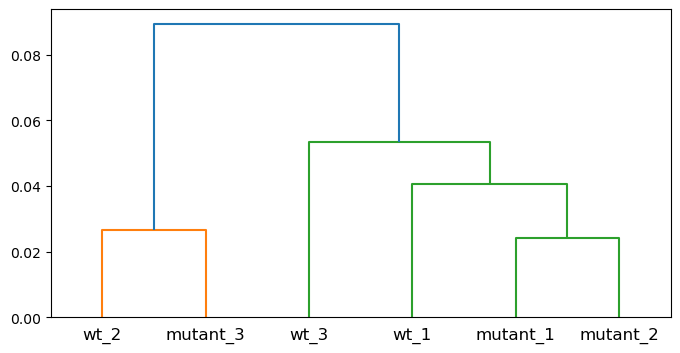

In [55]:
# クラスタリング
linkage_result = linkage(tpm_t, method='average', metric='correlation')

# 結果の可視化
plt.figure(num=None, figsize = (8,4), facecolor='w', edgecolor='k')
dendrogram(linkage_result,labels = list(tpm_t.index) )
plt.show()

参考：PCA

        PC1       PC2       PC3       PC4       PC5           PC6
0  0.655758  0.167141  0.095467  0.048019  0.033615  9.286607e-31


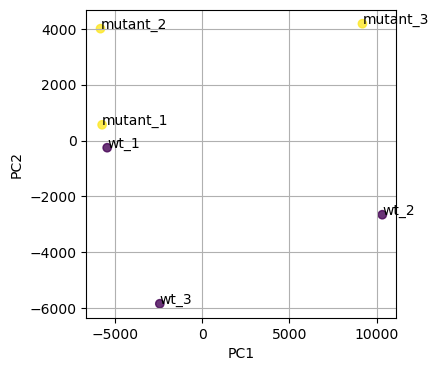

In [56]:
import sklearn
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(tpm_t)

# データを主成分空間に写像
pca_row = pca.transform(tpm_t)

# 寄与率を求める
pca_col = ["PC{}".format(x + 1) for x in range(len(tpm_t.index))]
df_con_ratio = pd.DataFrame([pca.explained_variance_ratio_], columns = pca_col)
print(df_con_ratio.head())

# PC1とPC2でplot
plt.figure(figsize=(4, 4))
plt.scatter(pca_row[:, 0], pca_row[:, 1], alpha=0.8, c=(1,1,1,2,2,2))
plt.grid()
plt.xlabel("PC1")
plt.ylabel("PC2")
annotations = tpm_t.index
for i, label in enumerate(annotations):
    plt.annotate(label, (pca_row[i, 0], pca_row[i, 1]))
plt.show()

### 5. 遺伝子アノテーションをつける

#### Step1. アノテーションファイルを読み込む

アノテーションデータ `annotation.tsv` はGRCm39のGFFファイル( `Mus_musculus.GRCm39.108.gff3` ) から必要な情報を抽出して作成しました<br>
`annotation.tsv`を開くと以下のようになっています<br>

```
ENSMUST00000070533.5	ENSMUSG00000051951	Xkr4	X-linked Kx blood group related 4 [Source:MGI Symbol;Acc:MGI:3528744]
ENSMUST00000208660.2	ENSMUSG00000025900	Rp1	retinitis pigmentosa 1 (human) [Source:MGI Symbol;Acc:MGI:1341105]
ENSMUST00000027032.6	ENSMUSG00000025900	Rp1	retinitis pigmentosa 1 (human) [Source:MGI Symbol;Acc:MGI:1341105]
ENSMUST00000027035.10	ENSMUSG00000025902	Sox17	SRY (sex determining region Y)-box 17 [Source:MGI Symbol;Acc:MGI:107543]
ENSMUST00000195555.2	ENSMUSG00000025902	Sox17	SRY (sex determining region Y)-box 17 [Source:MGI Symbol;Acc:MGI:107543]
...
```

In [57]:
# アノテーションデータ(transcript_id, gene_id, descriptionを紐づけたファイル ( annotation.tsv ) のパスを指定
annotation_file = 'data/annotation.tsv'

DataFrame名を `annotations` として、 <br>
ヘッダー（列名）は `names=['transcript_id', 'gene_id', 'gene_name', 'description']`として読み込みます

In [58]:
annotations = pd.read_table(annotation_file, names=['transcript_id', 'gene_id', 'gene_name', 'description'])
print(annotations.shape)
annotations.head()

(66511, 4)


,transcript_id,gene_id,gene_name,description
0,ENSMUST00000070533.5,ENSMUSG00000051951,Xkr4,X-linked Kx blood group related 4 [Source:MGI ...
1,ENSMUST00000208660.2,ENSMUSG00000025900,Rp1,retinitis pigmentosa 1 (human) [Source:MGI Sym...
2,ENSMUST00000027032.6,ENSMUSG00000025900,Rp1,retinitis pigmentosa 1 (human) [Source:MGI Sym...
3,ENSMUST00000027035.10,ENSMUSG00000025902,Sox17,SRY (sex determining region Y)-box 17 [Source:...
4,ENSMUST00000195555.2,ENSMUSG00000025902,Sox17,SRY (sex determining region Y)-box 17 [Source:...


#### Step2. アノテーションデータとカウントデータを連結
2つのDataFrame `df` と `annotations` を連結します<br>
`annotation` には mRNA のデータしか含まれていないので、rRNA などのデータはこの時点で除かれます<br>
ただし、`gene_name`列の値が `mt-` で始まるミトコンドリア遺伝子が含まれています

In [59]:
df_with_product = df.copy()
df_with_product['transcript_id'] = df_with_product.index
df_with_product.head()

,eff_length,wt_1,wt_2,wt_3,mutant_1,mutant_2,mutant_3,transcript_id
target_id,,,,,,,,
ENSMUST00000178537.2,6.74193,0.0,0.0,0.0,0.0,0.0,0.0,ENSMUST00000178537.2
ENSMUST00000178862.2,7.65825,0.0,0.0,0.0,0.0,0.0,0.0,ENSMUST00000178862.2
ENSMUST00000196221.2,5.34639,0.0,0.0,0.0,0.0,0.0,0.0,ENSMUST00000196221.2
ENSMUST00000179664.2,6.27959,0.0,0.0,0.0,0.0,0.0,0.0,ENSMUST00000179664.2
ENSMUST00000177564.2,8.56364,0.0,0.0,0.0,0.0,0.0,0.0,ENSMUST00000177564.2


In [60]:
df_with_product = pd.merge(df_with_product, annotations, on='transcript_id', how='inner')

In [61]:
# concatを使った場合
# pd.concat([gene_products, df], axis=1, join="inner")

In [62]:
# transcript_id列をindexにする
df_with_product.set_index('transcript_id', inplace=True)

アノテーション付きカウントデータを`count_preprocessed.tsv`として保存します<br>

In [63]:
# アノテーション付きデータの保存
df_with_product.to_csv('output/count_preprocessed.tsv', sep = '\t')

TPMデータにもアノテーション付与

In [64]:
df_tpm_with_product = df_count_tpm.copy()
df_tpm_with_product['transcript_id'] = df_tpm_with_product.index
df_tpm_with_product = pd.merge(df_tpm_with_product, annotations, on='transcript_id', how='inner')
df_tpm_with_product.set_index('transcript_id', inplace=True)

df_tpm_with_product.head()

,wt_1,wt_2,wt_3,mutant_1,mutant_2,mutant_3,gene_id,gene_name,description
transcript_id,,,,,,,,,
ENSMUST00000082392.1,3827.160918,6997.591290,4142.728550,3760.466540,3431.461573,6816.806391,ENSMUSG00000064341,mt-Nd1,mitochondrially encoded NADH dehydrogenase 1 [...
ENSMUST00000082396.1,2789.780229,4888.041645,2494.352104,2340.315938,2465.722778,4939.294983,ENSMUSG00000064345,mt-Nd2,mitochondrially encoded NADH dehydrogenase 2 [...
ENSMUST00000082402.1,5473.715014,11775.036281,6695.282675,7199.326865,7677.455631,11257.516939,ENSMUSG00000064351,mt-Co1,mitochondrially encoded cytochrome c oxidase I...
ENSMUST00000082405.1,4091.154892,8624.462767,3794.312528,2514.256397,3667.110133,8602.764457,ENSMUSG00000064354,mt-Co2,mitochondrially encoded cytochrome c oxidase I...
ENSMUST00000082407.1,3457.787163,6542.109723,3499.266048,3228.979622,3243.172745,7595.596472,ENSMUSG00000064356,mt-Atp8,mitochondrially encoded ATP synthase 8 [Source...


In [65]:
# アノテーション付きデータの保存
df_tpm_with_product.to_csv('output/tpm_with_product.tsv', sep = '\t')

### 6. 発現変動遺伝子を抽出する

TPM正規化データを用います<br>
wild typeの平均を求めます

In [66]:
df_count_tpm['wt'] = (df_count_tpm['wt_1'] + df_count_tpm['wt_2'] + df_count_tpm['wt_3']) / 3

mutantの平均を求めます

In [67]:
df_count_tpm['mutant'] = (df_count_tpm['mutant_1'] + df_count_tpm['mutant_2'] + df_count_tpm['mutant_3']) / 3

発現変動をlog2 fold として求めます<br>
0 での除算を防ぐため、分母に微小な値を加えています<br>

In [68]:
df_count_tpm['log2fold'] = df_count_tpm['mutant'] / (df_count_tpm['wt'] + 10**-6)
df_count_tpm['log2fold'] = df_count_tpm['log2fold'].apply(np.log2)

In [69]:
df_count_tpm.iloc[6085:6090,]

,wt_1,wt_2,wt_3,mutant_1,mutant_2,mutant_3,wt,mutant,log2fold
target_id,,,,,,,,,
ENSMUST00000212686.2,13.375947,14.821739,22.403762,18.415533,36.517768,8.398009,16.867149,21.110437,0.323740
ENSMUST00000034369.10,13.106564,8.277109,15.581013,14.654594,25.243265,15.944429,12.321562,18.614096,0.595210
ENSMUST00000212938.2,6.836943,3.819315,5.853242,6.041180,0.000000,1.653678,5.503167,2.564953,-1.101330
ENSMUST00000212876.2,0.000000,1.468917,0.000000,0.002062,7.556400,2.798090,0.489639,3.452184,2.817716
ENSMUST00000212595.2,13.309972,4.883908,5.236949,5.128239,1.434403,0.000000,7.810276,2.187548,-1.836059


必要部分のみ抜き出し、productと結合します<br>
`df_count_tpm` から'wt', 'mutant', 'log2fold'の列を抜き出し`diff_ex`とします

In [70]:
diff_ex = df_count_tpm.copy()
diff_ex = diff_ex[['wt', 'mutant', 'log2fold']]
diff_ex ['transcript_id']= diff_ex.index

In [71]:
diff_ex = pd.merge(diff_ex, annotations, on = 'transcript_id', how = 'right')
diff_ex.set_index('transcript_id', inplace = True)

In [72]:
diff_ex.head()

,wt,mutant,log2fold,gene_id,gene_name,description
transcript_id,,,,,,
ENSMUST00000070533.5,0.016716,0.478301,4.838570,ENSMUSG00000051951,Xkr4,X-linked Kx blood group related 4 [Source:MGI ...
ENSMUST00000208660.2,0.009890,0.000000,-inf,ENSMUSG00000025900,Rp1,retinitis pigmentosa 1 (human) [Source:MGI Sym...
ENSMUST00000027032.6,0.003724,0.007725,1.052415,ENSMUSG00000025900,Rp1,retinitis pigmentosa 1 (human) [Source:MGI Sym...
ENSMUST00000027035.10,0.000000,0.000000,-inf,ENSMUSG00000025902,Sox17,SRY (sex determining region Y)-box 17 [Source:...
ENSMUST00000195555.2,0.008930,0.032763,1.875142,ENSMUSG00000025902,Sox17,SRY (sex determining region Y)-box 17 [Source:...


カウント数が0であるデータを除きます

In [73]:
diff_ex = diff_ex[diff_ex['wt'] > 0]
diff_ex = diff_ex[diff_ex['mutant'] > 0]

In [74]:
diff_ex.shape

(42015, 6)

In [75]:
diff_ex.head()

,wt,mutant,log2fold,gene_id,gene_name,description
transcript_id,,,,,,
ENSMUST00000070533.5,0.016716,0.478301,4.838570,ENSMUSG00000051951,Xkr4,X-linked Kx blood group related 4 [Source:MGI ...
ENSMUST00000027032.6,0.003724,0.007725,1.052415,ENSMUSG00000025900,Rp1,retinitis pigmentosa 1 (human) [Source:MGI Sym...
ENSMUST00000195555.2,0.008930,0.032763,1.875142,ENSMUSG00000025902,Sox17,SRY (sex determining region Y)-box 17 [Source:...
ENSMUST00000191939.2,0.024349,0.146222,2.586177,ENSMUSG00000025902,Sox17,SRY (sex determining region Y)-box 17 [Source:...
ENSMUST00000130201.8,2.980996,1.404258,-1.085987,ENSMUSG00000033845,Mrpl15,mitochondrial ribosomal protein L15 [Source:MG...


`diff_ex.sort_values()`を使い`log2fold`の降順に並びかえます

In [76]:
diff_ex = diff_ex.sort_values(by = 'log2fold',ascending = False)

発現変動遺伝子の上位を表示してみましょう

In [77]:
# mutant > wt の上位5番目まで表示
diff_ex.head()

,wt,mutant,log2fold,gene_id,gene_name,description
transcript_id,,,,,,
ENSMUST00000098911.10,7.457162e-09,20.100816,24.250032,ENSMUSG00000074457,S100a16,S100 calcium binding protein A16 [Source:MGI S...
ENSMUST00000144576.8,7.056743e-09,8.935712,23.081006,ENSMUSG00000062963,Ufc1,ubiquitin-fold modifier conjugating enzyme 1 [...
ENSMUST00000077182.13,1.317549e-08,8.945620,23.073866,ENSMUSG00000033768,Nrxn2,neurexin II [Source:MGI Symbol;Acc:MGI:1096362]
ENSMUST00000052776.4,6.085283e-07,12.143848,22.847981,ENSMUSG00000050799,H2bc1,H2B clustered histone 1 [Source:MGI Symbol;Acc...
ENSMUST00000138759.8,6.809789e-08,6.050536,22.433588,ENSMUSG00000061046,Haghl,hydroxyacylglutathione hydrolase-like [Source:...


In [78]:
# wt > mutant の上位5番目まで表示
diff_ex.tail()

,wt,mutant,log2fold,gene_id,gene_name,description
transcript_id,,,,,,
ENSMUST00000113727.8,1.105071,2.105748e-10,-32.289088,ENSMUSG00000024862,Klc2,kinesin light chain 2 [Source:MGI Symbol;Acc:M...
ENSMUST00000234489.2,1.834887,3.020251e-10,-32.500304,ENSMUSG00000039183,Nubp2,nucleotide binding protein 2 [Source:MGI Symbo...
ENSMUST00000193200.6,0.557938,8.821290e-11,-32.558398,ENSMUSG00000067629,Syngap1,synaptic Ras GTPase activating protein 1 homol...
ENSMUST00000120753.3,0.662754,6.192146e-11,-33.317316,ENSMUSG00000030530,Furin,furin (paired basic amino acid cleaving enzyme...
ENSMUST00000107739.8,0.763148,6.270177e-11,-33.502739,ENSMUSG00000001507,Itga3,integrin alpha 3 [Source:MGI Symbol;Acc:MGI:96...


参考
- 実験医学別冊　独習Pythonバイオ情報解析　第6,7章　(2021年、先進ゲノム解析研究推進プラットフォーム編、ISBN978-4-7581-2249-8)
- pandas 公式サイト　https://pandas.pydata.org
- note.nknk.me pandas関連記事まとめ　https://note.nkmk.me/python-pandas-post-summary/